# Settings
## Import modules

In [1]:
import os
import natsort
import librosa, librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np
# file = './MeaningOfYou_drums(MIDI)_cut.wav'
# file = './MeaningOfYou_drums(HPSS)_cut.wav'

### Initialize & Checking Folders (Path)

In [2]:
# Audio Data (Source)
audio_list_path = './audio_list'
audio_list = natsort.natsorted(os.listdir(audio_list_path))
print(f"Audio_list : {audio_list}")

# Results 
result_path = './result'
result = natsort.natsorted(os.listdir(result_path))
print(f"Result : {result}")

Audio_list : ['MeaningOfYou_drums(MIDI).wav']
Result : ['MeToYou_drums(MIDI)']


## Defining three methods 
### 1. Extract only percussive sound(drum) from audio samples

In [3]:
# showing audio samples
audio_list = natsort.natsorted(os.listdir(audio_list_path))
print(f"Let's extract percussive sound from {audio_list}")

Let's extract percussive sound from ['MeaningOfYou_drums(MIDI).wav']


In [4]:
# audio_data --> percussive_data 
def percussive_audio_data(audio_file, save_file):
    # loading .wav file 
    y, sr = librosa.load(audio_file, sr=44100)
    print(f"sample rate (sr) : {sr}")
    
    # Future Work (현재는 드럼 소리만 있는 데이터) 
    # - "Harmonic Percussive Source Seperation(HPSS)" or "Spleeter"
    
    # ver.0
    # harmonic, percussive = librosa.decompose.hpss(librosa.stft(y))
    # y = librosa.istft(percussive)
    # #######################################
    # y = ((y-min(y))/(max(y)-min(y)))*1.4-0.7
    # #######################################
    
    # ver.1
    # y = librosa.effects.percussive(y)
    
    # ver.2
    # y = librosa.effects.percussive(y, margin=3.0)
    
    # showing the waveform (of the percussive source only)
    plt.figure(figsize=(12,4))
    librosa.display.waveshow(y, alpha=0.5, sr=sr)
    plt.xlabel("Time (s)")
    plt.ylabel("Aplitude")
    plt.title(f"{save_file}")
    
    # saving new file (only percussive sound)
    sf.write(save_file + '.wav', y, sr)
    print(f"'{save_file}'.wav extracted from '{audio_file}'\n")
    

./result\MeaningOfYou_drums(MIDI) folder created.
sample rate (sr) : 44100
'./result\MeaningOfYou_drums(MIDI)/MeaningOfYou_drums(MIDI)_p'.wav extracted from './audio_list/MeaningOfYou_drums(MIDI).wav'

##################################################################
Extracted complete ['MeaningOfYou_drums(MIDI)_p.wav']


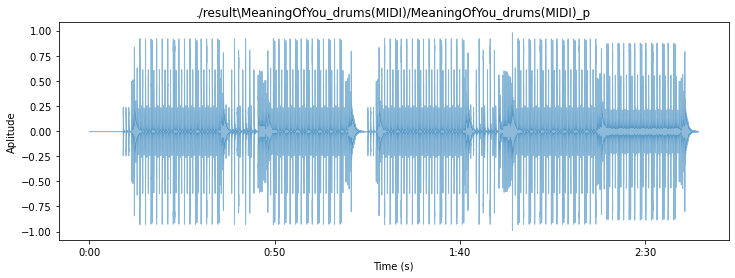

In [5]:
percussive_list = list()
# extracting only percussive sound from .wav file 
for audio in audio_list:
    # setting audio_path in a result directory
    audio_path = os.path.join(result_path, audio[:-4])
    percussive_list.append(audio[:-4] + '_p.wav')
    
    # Generating audio directory in a result directory
    try:
        os.makedirs(audio_path)
        print(f"{audio_path} folder created.")
    except:
        print("You already have folders")
    
    if audio.find('wav') != -1:
        # Setting source path & save path 
        audio_file = audio_list_path + '/' + audio
        percussive_file = audio_path + '/' + audio[:-4] + '_p'
        percussive_audio_data(audio_file, percussive_file)     

print("##################################################################")
print(f"Extracted complete {percussive_list}")

### 2. Trim percussive sound one by one

In [6]:
# checking percussive_list
print("Let's split percussive sound by using Onset Detection.")
print(percussive_list)

Let's split percussive sound by using Onset Detection.
['MeaningOfYou_drums(MIDI)_p.wav']


In [7]:
# percussive_data --> trim_data 
def trim_percussive_data(percussive_file, save_file, path):
    # loading .wav file
    
#     y, sr = librosa.load(percussive_file)
#     y, sr = librosa.load(percussive_file, sr=44100)
#     # onset detection
#     onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)
#     # print(onset_frames)
#     onset_time = librosa.frames_to_time(onset_frames, sr=sr)
#     # print(onset_time)
    
    y, sr = librosa.load(percussive_file, sr=44100)
    oenv = librosa.onset.onset_strength(y=y, sr=sr)
    times = librosa.times_like(oenv, sr=sr)
    # Detect events without backtracking
    onset_raw = librosa.onset.onset_detect(onset_envelope=oenv, backtrack=False, sr=sr)
    onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)
    
    onset_time = times[onset_bt]
    
    f = open(path + "/onset_time.txt", 'w')
    print(f"{len(onset_time)} event(s) has been detected.")
    
    # Trim, using Onset Detection Time
    plt.figure(figsize=[20,55])
    for i in range(len(onset_time)-1):
        tmp = onset_time[i+1] - onset_time[i]
        if tmp > 0.1475:
            ny = y[int(sr*(onset_time[i]-0.01)):int(sr*(onset_time[i]+0.1475))]
            ny = np.concatenate((np.random.normal(loc=0, scale=0.003, size=int(sr*(0.01))), ny, np.random.normal(loc=0, scale=0.003, size=int(sr*(0.02)))))
        else:
            ny = y[int(sr*(onset_time[i]-0.01)):int(sr*(onset_time[i+1]))]
            ny = np.concatenate((np.random.normal(loc=0, scale=0.003, size=int(sr*(0.01))), ny, np.random.normal(loc=0, scale=0.003, size=int(sr*(0.1675 - tmp)))))
        # print(f"{i+1} : {round(onset_time[i], 4)} s\t\t next : {round(tmp,4)}")
        
        # showing the waveform of each sounds
        # plt.subplot(58,1,i+1)
        # plt.plot(ny)
        # plt.ylim(-0.7,0.7)
        
        # saving files (trimmed samples)
        trim_file = save_file + '_' + str(i + 1)
        sf.write(trim_file + '.wav', ny, sr)
        f.write(str(onset_time[i]) +'\n')
        # print(f"{onset_time[i]} \t(sec): '{trim_file}' created.")
        # print(len(ny)/sr)
        
    # saving last file
    # sr=22050 --> 4134 | sr=44100 --> 8268
    ny = y[int(sr*(onset_time[i+1]-0.01)):]
    if len(ny) <= 8268:
        ny = np.append(ny, np.random.normal(loc=0, scale=0.003, size=8268-len(ny)))
    else:
        ny = ny[:8268]
    # print(f"{i+2} : {round(onset_time[i+1], 4)} s")

    trim_file = save_file + '_' + str(i + 2)
    sf.write(trim_file + '.wav', ny, sr)
    f.write(str(onset_time[i+1]) +'\n')
        
    f.close()
    print(f"Trim finished.\nAll files are {len(ny)/sr} sec long.\n\n")
    

In [8]:
trim_path_list = list()

for percussive_name in percussive_list:
    print(f"Start Trim '{percussive_name}'")
    # setting percussive_path & trim_path in a result directory
    percussive_path = result_path + '/' + percussive_name[:-6]
    trim_path = percussive_path + '/trim'
    trim_path_list.append(trim_path)
    
    # Generating trim directory in a result/audio directory
    try:
        os.makedirs(trim_path)
        print(f"{trim_path} folder created.")
    except:
        print("You already have folders")
        
    if percussive_name.find('wav') != -1:
        # Setting source path & save path 
        percussive_file = percussive_path + '/' + percussive_name
        trim_file = trim_path + '/' + percussive_name[:-4]
        trim_percussive_data(percussive_file, trim_file, percussive_path)

Start Trim 'MeaningOfYou_drums(MIDI)_p.wav'
./result/MeaningOfYou_drums(MIDI)/trim folder created.
383 event(s) has been detected.
Trim finished.
All files are 0.1874829931972789 sec long.




<Figure size 1440x3960 with 0 Axes>

### 3. Make Trim data(.wav) into Mel-Spectrogram(.jpg)

In [9]:
# checking trim_path_list
print("Let's extract mel-spectograms from trim data")
print(trim_path_list)

Let's extract mel-spectograms from trim data
['./result/MeaningOfYou_drums(MIDI)/trim']


In [10]:
def Mel_data(trim_path_list):
        for trim_path in trim_path_list:
            # setting mel_path in a result directory
            mel_path = trim_path[:-4] + 'mel'
            
            # Generating trim directory in a result/audio directory 
            try:
                os.makedirs(mel_path)
                print(f"{mel_path} folder created.")
            except:
                print("You already have folders")
                
            for t in natsort.natsorted(os.listdir(trim_path)):
                sample, sr = librosa.load(trim_path + '/' + t, sr=44100)
                if len(sample) < 1700 :
                    print("Error (1700)")
                    continue
                # warnings.filterwarnings(action='ignore')

                # mel
                plt.figure(figsize=(6.898,4.719))
                f_sample=librosa.feature.melspectrogram(y = sample, sr=sr)
                librosa.display.specshow(librosa.power_to_db(f_sample), cmap='jet', y_axis='mel')
                plt.clim(-70,20)
                plt.axis('off')
                plt.savefig(fname= mel_path + '/' + t + '_mel.jpg', bbox_inches='tight', pad_inches=0)
                plt.close()
            print(f"Complete saving {mel_path}\n")
        
        print("######### Complete saving all mel_spectrograms #########")

In [11]:
Mel_data(trim_path_list)

./result/MeaningOfYou_drums(MIDI)/mel folder created.
Complete saving ./result/MeaningOfYou_drums(MIDI)/mel

######### Complete saving all mel_spectrograms #########


In [12]:
# checking mel directories
mel_path_list = list()
for t in trim_path_list:
    mel_path_list.append(t[:-4] + 'mel')
print (mel_path_list)

['./result/MeaningOfYou_drums(MIDI)/mel']


### 4. Make Trim data(.wav) into wavform(.jpg)

In [13]:
# checking trim_path_list
print("Let's extract wavform from trim data")
print(trim_path_list)

Let's extract wavform from trim data
['./result/MeaningOfYou_drums(MIDI)/trim']


In [14]:
def Wav_data(trim_path_list):
        for trim_path in trim_path_list:
            # setting wav_path in a result directory
            wav_path = trim_path[:-4] + 'wav'
            
            # Generating trim directory in a result/audio directory 
            try:
                os.makedirs(wav_path)
                print(f"{wav_path} folder created.")
            except:
                print("You already have folders")
                
            for t in natsort.natsorted(os.listdir(trim_path)):
                sample, sr = librosa.load(trim_path + '/' + t, sr=44100)
                if len(sample) < 1700 :
                    print("Error (1700)")
                    continue
                # warnings.filterwarnings(action='ignore')

                # mel
                plt.figure(figsize=(6.898,4.719))
                plt.plot(sample)
                plt.xlim(0, len(sample))
                plt.ylim(-0.7,0.7)
                plt.axis('off')
                plt.savefig(fname= wav_path + '/' + t + '_wav.jpg', bbox_inches='tight', pad_inches=0)
                plt.close()
            print(f"Complete saving {wav_path}\n")
        
        print("######### Complete saving all wavforms #########")

In [15]:
Wav_data(trim_path_list)

./result/MeaningOfYou_drums(MIDI)/wav folder created.
Complete saving ./result/MeaningOfYou_drums(MIDI)/wav

######### Complete saving all wavforms #########


In [16]:
# # checking wav directories
# wav_path_list = list()
# for t in trim_path_list:
#     wav_path_list.append(t[:-4] + 'wav')
# print (wav_path_list)

# Test 
## EfficientNet-B0 & Trained model parameters

In [17]:
import torch, json
from torch.utils.data import DataLoader

# User define Modules
from drumdataset_load import DrumDataset_test
from models import EfficientNet
from math import ceil

In [18]:
with open('./info.json', 'r') as f:
    info = json.load(f)
    
labels = info["labels"]

In [20]:
for mel_path in mel_path_list:
    test_dataset = DrumDataset_test(labels, mel_path)
    test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = 0)
    del test_dataset

    save_path = mel_path[:-3]
    para_path="./parameters/parameter/efficientnet_b0_result_mel_aug.pth"
    net = EfficientNet.from_name('efficientnet-b0',in_channels=3, num_classes = 23)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.load_state_dict(torch.load(para_path))
    net.eval()
    net.to(device)
    
    print(f"\n########## {save_path[:-1]} ##########")
    
    f = open(save_path + 'onset_time.txt', 'r')
    onset_time = f.readlines()
    f. close()
    onset_time = list(map(lambda s: s.strip(), onset_time))
    
    time_sum, rest, bar = 0, 0, 1
    ##############################
    ##############################
    bpm = 80 ## !!! Set BPM !!! ##
    ##############################
    ##############################
    dominant_time = bpm / 100  # 100 bpm (standard)
    print(save_path[9:-1])
    with torch.no_grad():
        f = open(save_path + save_path[9:-1] + '_score.txt', 'w')
        f2 = open(save_path + save_path[9:-1] + '_score_analysis.txt', 'w')
        i, prev_class, right_hand, left_hand, right_speed, left_speed, right_foot, left_foot = 0, -1, 0, 0, 0, 0, 0, 0 
        print(1, '\t', format(0.6, ".3f"), '\t', 0, '\t', 0, '\t', 0, '\t', 0, '\t', 0, '\t', 0, file=f)
        for input_test,_ in test_loader:
            input_test = input_test.cuda()
            input_test = input_test.to("cuda").float()

            pred_test = net(input_test)
            sfmx = torch.nn.Softmax(dim=1)
            # print(sfmx(pred_test))
            
            # Top 1
            _, predicted = torch.max(pred_test, 1)
            drum_class = predicted.item()
            # Top 3
            _, predicted_3 = torch.topk(pred_test, 3)
            nparray = np.squeeze(predicted_3.cpu().numpy(), axis=0)
            nparray2 = np.squeeze(sfmx(pred_test).cpu().numpy(), axis=0)
            
            # Print Log (to check results)
            # print(i+1, ' : ', round(float(onset_time[i]),4), 'sec  \t: ', labels[predicted.item()])
            # print(i+1, '\t', round(float(onset_time[i]),4), 'sec\t(',labels[nparray[0]], ', ', round(nparray2[nparray[0]] * 100, 2), end="% )\t")
            # if nparray2[nparray[0]] < 0.8 :
            #     print('(', labels[nparray[1]], ', ', round(nparray2[nparray[1]] * 100, 2), end="% )\t")
            #     print('(', labels[nparray[2]], ',', round(nparray2[nparray[2]] * 100, 2), end="% )")
            # print()
            
            # Initialize Time
            if i == 0:
                time = float(onset_time[0]) * dominant_time 
            else:
                time = (float(onset_time[i]) - float(onset_time[i-1])) * dominant_time
                
            if i+1 < len(onset_time):
                time_2 = (float(onset_time[i+1]) - float(onset_time[i])) * dominant_time
            else:
                time_2 = 0
            
            # Time Re-arrange
            if 3 < time: # long rest
                time = round((round(time, 2) // 0.3) * 0.3, 2)
                bar += int(time // 2.4)  # 2.4 seconds is the time of a bar (standard : 100bpm)
                rest = time % 2.4
                # print(f"time : {time}")
            elif 1.8 <= time < 3: # whole note
                time = 2.4
            elif 0.8 <= time < 1.6: # half note
                time = 1.2
            elif 0.47 <= time < 0.72: # quarter note
                time = 0.6
            elif 0.41 <= time < 0.47:
                time = 0.45
            elif 0.225 <= time < 0.375: # eighth note
                time = 0.3
            elif 0.194 <= time < 0.225: # 12th note (12분음표)
                # print(f"12th NOTE : {time} | {labels[predicted.item()]}\n")
                time = 0.2
            elif 0.122 <= time < 0.194: # sixteenth note
                time = 0.15
            elif time < 0.122: # 24th note (24분음표)
                time = 0.1
            # elif time < 0.077: # thirtysecond note (32분음표)
            #     time = 0.075
            else:
                print(f"time : {time}")
                print(f"CHECK THE ONSET TIME :\n {onset_time[i-1]}\n {onset_time[i]}\n")
            
            # Time2 Re-arrange
            if 3 < time_2: # long rest
                time_2 = round((round(time_2 % 2.4, 2) // 0.3) * 0.3, 2)
            elif 1.8 <= time_2 < 3: # whole note
                time_2 = 2.4
            elif 0.8 <= time_2 < 1.6: # half note
                time_2 = 1.2
            elif 0.47 <= time_2 < 0.72: # quarter note
                time_2 = 0.6
            elif 0.41 <= time_2 < 0.47:
                time_2 = 0.45
            elif 0.225 <= time_2 < 0.375: # eighth note
                time_2 = 0.3
            elif 0.194 <= time_2 < 0.225: # 12th note (12분음표)
                # print(f"12th NOTE : {time_2} | {labels[predicted.item()]}\n")
                time_2 = 0.2
            elif 0.122 <= time_2 < 0.194: # sixteenth note
                time_2 = 0.15
            elif time_2 < 0.122: # 24th note (24분음표)
                time_2 = 0.1
            # elif time_2 < 0.077: # thirtysecond note (32분음표)
            #     time_2 = 0.075
            else:
                print(f"time_2 : {time_2}")
                
            # Set bar
            # print(f"time_2 : {time_2}")
            time_sum += time_2
            if 2.45 < time_sum and time_sum - time_2 > 1.8:
                time_sum -= 2.4
                bar += 1
            time_sum = round(time_sum, 2)
                     
            # Set right_hand, right_speed
            if drum_class in [0, 1, 2, 3, 4, 5, 12, 14, 21]: # CH or OH 
                if drum_class == 3 or drum_class == 14:
                    right_hand, right_speed = 5, 2
                else:
                    right_hand, right_speed = 5, 1
            elif drum_class in [8, 9, 10, 19]: # R
                right_hand, right_speed = 7, 0.2
            elif drum_class in [11, 18]: # C? C2?
                if prev_class in [15, 16, 20, 22] or right_hand == 6: # FT or R
                    right_hand, right_speed = 8, 1 # C2
                else:
                    right_hand, right_speed = 6, 1 # C
            elif drum_class == 7: # S
                if prev_class in [0, 1, 2, 3, 4, 5, 7, 12, 14, 21] and time <= 0.375 and left_hand == 0:
                    right_hand, right_speed = 0, 0
                else:
                    right_hand, right_speed = 1, 1
            elif drum_class == 13: # MT
                if ((prev_class == 7 and time <= 0.375) or prev_class == 13) and left_hand == 0:
                    right_hand, right_speed = 0, 0
                else:
                    right_hand, right_speed = 2, 1
            elif drum_class in [15, 16, 20, 22]: # FT
                if prev_class == 15 or prev_class == 20:
                    right_hand, right_speed = 0, 0
                else:
                    right_hand, right_speed = 4, 1
            else:
                right_hand, right_speed = 0, 0
            
            # Set left_hand, left_speed
            if drum_class in [3, 4, 10, 14, 16, 17, 18, 19, 21]: # S
                if drum_class == 3 or drum_class == 14:
                    left_hand, left_speed = 1, 2
                else:
                    left_hand, left_speed = 1, 1
            elif drum_class == 13 and ((prev_class == 7 and time <= 0.375) or prev_class == 13) and left_hand == 0: # MT
                left_hand, left_speed = 2, 1
            elif drum_class in [15, 20] and prev_class in [15, 20]:
                left_hand, left_speed = 4, 1
            elif drum_class == 7 and prev_class in [0, 1, 2, 3, 4, 5, 7, 12, 14, 21] and time <= 0.375 and left_hand == 0:
                    left_hand, left_speed = 1, 1
            else:
                left_hand, left_speed = 0, 0
             
            # Set right_foot
            if drum_class in [1, 5, 6, 9, 11, 14, 17, 19, 20, 21]:
                right_foot = 1
            else:
                right_foot = 0
                
            # Set left_foot 
            if drum_class in [0, 1, 3, 12, 14]: # Hi-hat close --> 1
                left_foot = 1
            elif drum_class in [4, 5, 21] and left_foot == 1: # Hi-hat open --> 0 or 2
                left_foot = 2
            
            # Debug
            # if i > 0:
            #     print(bar,'\t', format(round(time, 3), ".3f"), format(round((float(onset_time[i]) - float(onset_time[i-1])) * dominant_time, 3), ".3f"), '\t', labels[predicted.item()], '\t time : ', time_sum)
            # print(bar,'\t', format(round(float(onset_time[i]), 3), ".3f"), '\t', labels[predicted.item()])
            
            # For analysis (score_analysis.txt)
            interval = format(round(time_2, 3), ".3f")
            if interval == '0.100':
                note = '1/24'
            elif interval == '0.150':
                note = '1/16'
            elif interval == '0.200':
                note = '1/12'
            elif interval == '0.300':
                note = '1/8'
            elif interval == '0.450':
                note = '3/16'
            elif interval == '0.600':
                note = '1/4'
            elif interval == '1.200':
                note = '1/2'
            else:
                note = '?\t'
            print(bar,'\t', labels[predicted.item()], '\tnote: ', note, '\tonset : ', format(round(float(onset_time[i]), 3), ".3f"),  file=f2)
            
            print(bar, '\t', format(round(time, 3), ".3f"), '\t', right_hand, '\t', left_hand, '\t', right_speed, '\t', left_speed, '\t', right_foot, '\t', left_foot, file=f)
            
            ### First Trial, Classified by drum class ###
            # if drum_class == 0 or drum_class == 12: # CH
            #     # if prev_class == 0:
            #     #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 0, '\t', 5, '\t', 0, '\t', 1, '\t', 0, '\t', left_foot, file=f)
            #     # else:
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 5, '\t', 0, '\t', 1, '\t', 0, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 1: # B+CH
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 5, '\t', 0, '\t', 1, '\t', 0, '\t', 1, '\t', left_foot, file=f)
            # elif drum_class == 2: # OH
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 5, '\t', 0, '\t', 1, '\t', 0, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 3: # S+CH
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 5, '\t', 1, '\t', 2, '\t', 2, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 4: # S+OH
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 5, '\t', 1, '\t', 2, '\t', 2, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 5: # B+OH
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 5, '\t', 0, '\t', 1, '\t', 0, '\t', 1, '\t', left_foot, file=f)
            # elif drum_class == 6: # B
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 0, '\t', 0, '\t', 0, '\t', 0, '\t', 1, '\t', left_foot, file=f)
            # elif drum_class == 7: # S
            #     if prev_class == 7:
            #         print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 0, '\t', 1, '\t', 0, '\t', 1, '\t', 0, '\t', left_foot, file=f)
            #     else:
            #         print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 1, '\t', 0, '\t', 1, '\t', 0, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 8: # R
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 7, '\t', 0, '\t', 0.2, '\t', 0, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 9: # B+R
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 7, '\t', 0, '\t', 0.2, '\t', 0, '\t', 1, '\t', left_foot, file=f)
            # elif drum_class == 10: # S+R
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 7, '\t', 1, '\t', 0.2, '\t', 1, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 11: # B+C
            #     if prev_class == 15 or prev_class == 16 or prev_class == 20 or prev_class == 22:
            #         print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 8, '\t', 0, '\t', 1, '\t', 0, '\t', 1, '\t', left_foot, file=f)
            #     else:
            #         print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 6, '\t', 0, '\t', 1, '\t', 0, '\t', 1, '\t', left_foot, file=f)
            # # elif drum_class == 12: # rest --> CH
            # #     #print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 0, '\t', 0, '\t', 0, '\t', 0, '\t', 0, '\t', left_foot, file=f)
            # #     tmp = time
            # elif drum_class == 13: # MT
            #     #print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 2, '\t', 0, '\t', 1, '\t', 0, '\t', 0, '\t', left_foot, file=f) #High-Tom
            #     if prev_class == 7 or drum_class == 13:
            #         print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 0, '\t', 3, '\t', 0, '\t', 1, '\t', 0, '\t', left_foot, file=f)
            #     else:
            #         print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 3, '\t', 0, '\t', 1, '\t', 0, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 14: # S+B+CH
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 5, '\t', 1, '\t', 1, '\t', 1, '\t', 1, '\t', left_foot, file=f)
            # elif drum_class == 15: # FT
            #     if prev_class == 13 or prev_class == 15:
            #         print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 0, '\t', 4, '\t', 0, '\t', 1, '\t', 0, '\t', left_foot, file=f)
            #     else:
            #         print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 4, '\t', 0, '\t', 1, '\t', 0, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 16: # S+FT
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 4, '\t', 1, '\t', 1, '\t', 1, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 17: # S+B
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 0, '\t', 1, '\t', 0, '\t', 1, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 18: # S+C
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 6, '\t', 1, '\t', 1, '\t', 1, '\t', 0, '\t', left_foot, file=f)
            #     # print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 1, '\t', 8, '\t', 1, '\t', 0, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 19: # S+B+R
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 7, '\t', 1, '\t', 0.2, '\t', 1, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 20: # B+FT
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 0, '\t', 4, '\t', 0, '\t', 1, '\t', 0, '\t', left_foot, file=f)
            # elif drum_class == 21: # S+B+OH
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 5, '\t', 1, '\t', 1, '\t', 1, '\t', 2, '\t', left_foot, file=f)
            # elif drum_class == 22: # MT+FT
            #     print(labels[drum_class], '\t', format(round(time, 3), ".3f"), '\t', 3, '\t', 4, '\t', 1, '\t', 1, '\t', 0, '\t', left_foot, file=f)
            
            i+=1
            prev_class = drum_class
            
    # print('end', '\t', format(0.3, ".3f"), '\t', 0, '\t', 0, '\t', 0, '\t', 0, '\t', 0, '\t', 2, file=f)
    print(bar, '\t', format(2.4-time_sum, ".3f"), '\t', 0, '\t', 0, '\t', 0, '\t', 0, '\t', 0, '\t', 2, file=f)
    print(bar+1, '\t', format(1.8, ".3f"), '\t', 1, '\t', 1, '\t', 1, '\t', 1, '\t', 1, '\t', 2, file=f)
    
    f.close()
    f2.close()
    
    print("Drum Intelligence, score extraction completed.")


########## ./result/MeaningOfYou_drums(MIDI) ##########
MeaningOfYou_drums(MIDI)
Drum Intelligence, score extraction completed.


In [ ]:
# print(labels)